<b>Group Number:</b> 7
<br><b>Name Group Member 1:</b>   Paraa Afifi
<br><b>u-Kürzel Group Member 1:</b>   uppns
<br><b>Name Group Member 2:</b>   Dan-Jason Bräuninger
<br><b>u-Kürzel Group Member 2:</b>   uuuab
<br><b>Name Group Member 3:</b> Sami Shahzad
<br><b>u-Kürzel Group Member 3:</b>uvoei

# Convolutional Neural Networks (CNNs) - Part 1

## 1.1 Basics

Neural Networks can be applied to various data, although to visual information Convolutional Neural Networks (CNNs) have shown to be more efficient and effective. In fact,
these models perform better than regular multiple hidden layer structures as long as regarded
data contains spatial dependencies. This precondition is given in images as pixel
values that relate spatially to each other. Inspired by filters, that were used in the era of
hard feature extraction in computer vision, these networks adapt their weights in form of `learnable filters` to project
the image in higher spatial dimensions. Features are defined as being a characteristic to
the observed data, starting in the first convolutional layers by representing an images' edges or `lower semantic` representation. Due to passing them further through a CNN,
those form into coarser `abstract attributes`, allowing the network to distinguish or classify single or multiple objects shown in an image. As an example the classification of a car is shown below. Note that `CONV` is an convolutional operation, `RELU` refers to the rectified linear unit and `POOL` describes a pooling layer to reduce image dimensions. These operations will be explained soon. 

![CNN feedforward](images/stanford_cnn.jpg "CNN_feedforward")


                                    Source: http://cs231n.github.io/convolutional-networks/

Different goals exist, when it comes to computer vision. You can find some of them shortly described below. 

- **Semantic Segmentation:**
Semantic segmentation involves classifying and labeling each pixel in an image, assigning it to a specific category. This technique is crucial for understanding the context and boundaries of objects within the image.
- **Classification:**
Classification is the process of assigning a label or category to an entire object or image based on its features. It is a fundamental task in machine learning, where the model learns to differentiate between different classes.
- **Classification + Localization:**
This task combines object classification with the added dimension of localization, determining the spatial position of the object in the image. It not only identifies what is in the image but also provides information about where the object is located.
- **Object Detection:**
Object detection goes a step further by identifying and outlining multiple objects within an image, along with assigning a category to each. This task is essential for applications where recognizing and locating various objects in a scene is necessary.
- **Instance Segmentation:**
Instance segmentation involves not only identifying object categories but also distinguishing between individual instances of the same category. This fine-grained task provides a pixel-level mask for each unique object in the image, offering detailed information about the spatial extent of each instance.

(Courtesy to ChatGPT)

![Computer vision tasks](images/cv_tasks.png "Computer vision tasks")

    Source: https://medium.com/@albertcstn/object-detection-with-deep-learning-r-cnn-model-family-7126ab0fa2a2


## 1.2 Imports

In [1]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import figure
import numpy as np
from scipy import signal
from scipy import datasets
from typing import *

## 1.3 Convolutional Operation

Like the name implies, the convolutional layer makes use of convolutions. As a short recap this small widget sums up the convolution of two rectangular functions. The convolution operation is given by the following equation in the continuous domain:

\begin{equation*}
x(t) \ast y(t) = \langle x(t - \tau), y^{\ast}(\tau) \rangle_{\tau} = \int_{-\infty}^{+\infty} x(t -\tau) y(\tau) d \tau
\end{equation*}

In [2]:
def convolution(tau: float, width1: float, width2: float):
    
    x1 = np.linspace(-3.5, 3.5, num = 1000)
    dX = x1[1] - x1[0]    
    rect1 = np.where(abs(x1) <= width1/2 , 1, 0)
    rect2 = np.where(abs(x1- tau)<= width2/2 , 1, 0)
    
    # Convolution of rect1 and rect2
    conv = np.convolve(rect1, rect2, 'same') * dX 
    
    
    # Plotting
    plt.figure(1, figsize=(16.5,3.5))
    plt.plot(x1, rect1, 'b', label = '$rect_{1}$(t)')
    plt.plot(x1, rect2, 'r', label = '$rect_{2}$(t- $\\tau$)')
    x_gr = x1 - tau
    if tau <=0:
        index = np.where((np.absolute(x_gr)-np.absolute(tau))<=0.004)
        index = index[0][0]
    else:
        index = np.where(np.absolute(x_gr-tau)<=0.004)
        if not index[0].size > 0:
            index = [[999]]
        index = index[0][0]
    plt.plot(x_gr[:index]  , conv[:index], 'g', label = '$rect_{1}$ $\\ast$ $rect_{2}$')
    plt.axvline(x = tau, color= 'r', dashes = [6,2])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size':15})
    plt.ylim(0,np.maximum(np.max(conv),np.max(rect1))+0.1)
    plt.xlim(-2.5, 2.5)
    plt.grid()
    plt.show()

In [3]:
# Interactive Plot
interactive_plot = interactive(convolution, tau = (-2.0, +2.0, 0.25), 
                               width1 = (0.25, 1.75, 0.25), 
                               width2 = (0.25, 1.75, 0.25))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='tau', max=2.0, min=-2.0, step=0.25), FloatSlider(val…

Of course the calculation of the convolution is not done in the continous domain. Therefore numpy uses the following formula for discrete convolution in 1-dimensional space:

\begin{equation*}
x_n \ast y_n = \sum_{i = -\infty}^{\infty} x_i  \  y_{n-i} = \sum_{i = -\infty}^{\infty} y_{i}  \ x_{n-i}
\end{equation*}

## 1.4 Filters and Convolution in Image Processing

The convolutional operation can be as well given in two dimensions:

\begin{equation*}
x_{mn} \ast \ast \ y_{mn} = \sum_{i = -\infty}^{\infty} \sum_{j = -\infty}^{\infty} x_{ij}  \  y_{m-i, n-j} = \sum_{i = -\infty}^{\infty} \sum_{j = -\infty}^{\infty} y_{ij}  \ x_{m-i, n-j}
\end{equation*}

With respect to convolution of images in the discrete domain, the limits change to finite values being the size of the images' shape.
This operation can then be visualized as the following:


<img src="images/Faltung1.png" alt="Drawing" style="width: 600px;"/>
<img src="images/Faltung2.png" alt="Drawing" style="width: 600px;"/>
<img src="images/Faltung3.png" alt="Drawing" style="width: 600px;"/>
<img src="images/Faltung4.png" alt="Drawing" style="width: 600px;"/>


Note the convolutional layer does not flip the filter as in conventional signal processing. From now on, images or spatial information in 3 dimensions is defined by:

 - Height $H$
 - Weight $W$
 - Depth $d$ (channels)
 
The discrete convolution reduces image dimensions like above. The following equation describes the reduction itself, in which $K$ denotes the `kernel` or filter dimensions, $P$ denotes additional values (usually to preserve outpout dimensions, called `padding`) and $S$ denotes the `stride`. There are several padding techniques p.ex. adding zeros (Zero Padding). If the stride is larger than 1, the kernel skips values in between during convolution.

\begin{align}
W_{i+1} = \dfrac{(W_{i}-K_{x}+2*P_{x})}{S_x}+1 \\
H_{i+1} = \dfrac{(H_{i}-K_{y}+2*P_{y})}{S_y}+1 
\end{align}


First we are starting off with an **gray image** called ascent, W is equal to the image's width and H to the image's height. Since this image is a gray scale image the depth $d=1$.

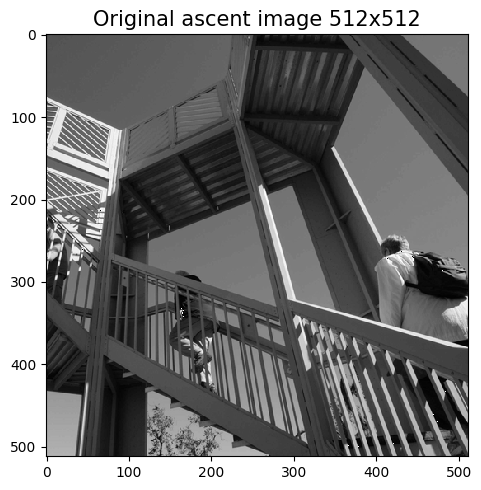

In [4]:
#Load Ascent image from scipy
ascent = datasets.ascent()

figure_inches = 5
fig, ax = plt.subplots(figsize=(figure_inches, figure_inches))
ax.set_title('Original ascent image 512x512', fontsize = 15)
ax.imshow(ascent, interpolation='nearest', cmap='gray')
plt.tight_layout()

In computer vision or image processing there are common filter matrices that are used to extract information out of an image or change the feature represenation. Learnable filters in the convolutional layer will change an image's representation as well. Those will be discussed later in the section about the convolutional layers.

In [5]:
# Some 3x3 filter matrices used in computer vision

# Mean-filter
mean = 1/9 * np.ones([9,9])

# Approximation of the gradient
prewitt_x =  np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
prewitt_y =  np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])

sobel_x =  np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y =  np.array([[-1, -2, 1], [0, 0, 0], [1, 2, 1]])

# Second-order derivation 
laplace_var = np.array([[0, 1, 0], [1, -4, 1],[0, 1, 0]])

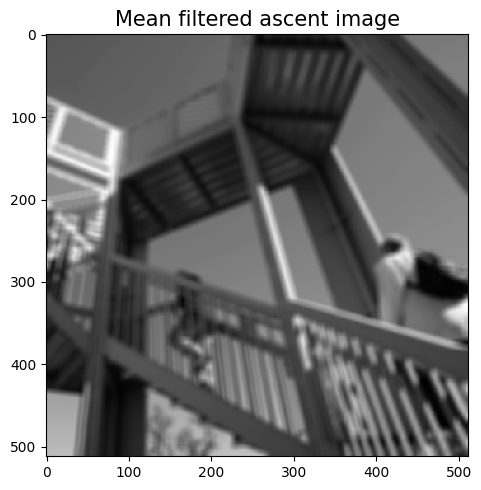

In [6]:
ascent_mean = signal.convolve2d(ascent, mean, boundary='symm', mode='same')
fig, ax = plt.subplots(figsize=(figure_inches, figure_inches))
ax.set_title('Mean filtered ascent image', fontsize = 15)
ax.imshow(ascent_mean, interpolation='nearest', cmap='gray')
plt.tight_layout()

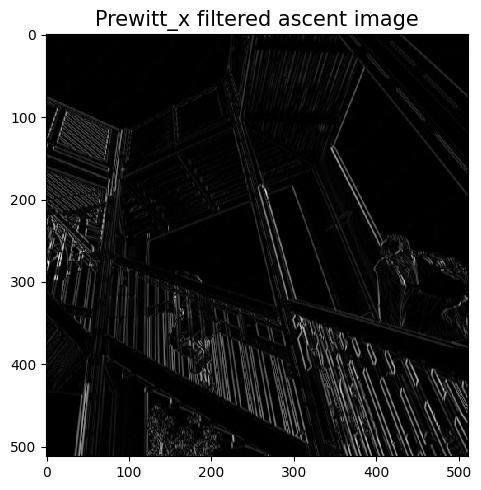

In [7]:
ascent_x_prew = signal.convolve2d(ascent, prewitt_x, boundary='symm', mode='same')
ascent_x_prew = np.absolute(ascent_x_prew)
fig, ax = plt.subplots(figsize=(figure_inches, figure_inches))
ax.set_title('Prewitt_x filtered ascent image', fontsize = 15)
ax.imshow(ascent_x_prew, interpolation='nearest', cmap='gray')
plt.tight_layout()

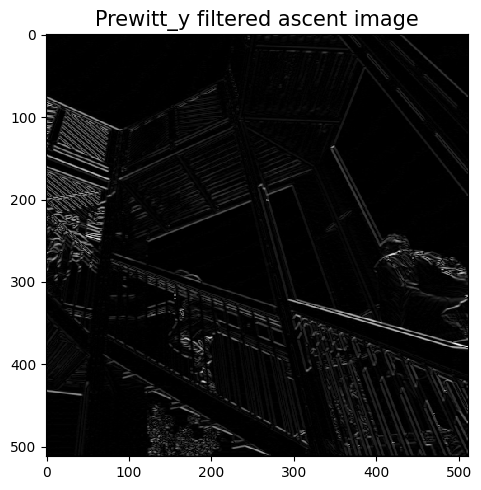

In [8]:
ascent_y_prew = signal.convolve2d(ascent, prewitt_y, boundary='symm', mode='same')
ascent_y_prew = np.absolute(ascent_y_prew)
fig, ax = plt.subplots(figsize=(figure_inches, figure_inches))
ax.set_title('Prewitt_y filtered ascent image', fontsize = 15)
ax.imshow(ascent_y_prew, interpolation='nearest', cmap='gray')
plt.tight_layout()

<div class="alert alert-block alert-success">
<b>Question (1 pts):</b> What for a linear Prewitt-Filter (x or y) is necessary to underline horizontal edges? 
</div>

<div class="alert alert-block alert-success">
<b>Your Answer: For horizontal edges, we need a Prewitt filter in the Y direction. The names 'x' or 'y' only tell us in which direction we move during the process.</b> 
</div>

## 1.5 RGB Images

Colored images can usually be given by RGB images, in which $d$ is equal to 3 and contains:

- R (red), 
- G (green),
- B (blue)

values for all pixels in an image.

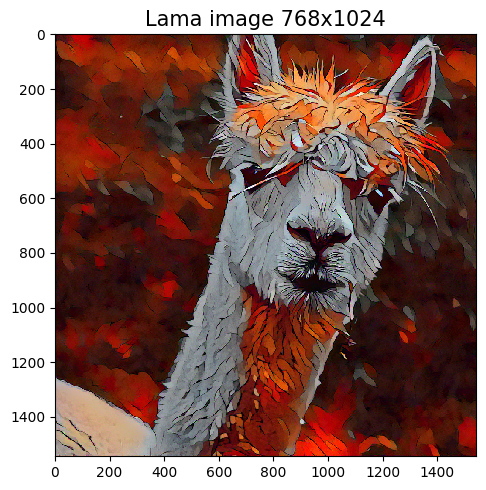

In [9]:
lama = Image.open('images/lama.png')
lama = np.array(lama)

fig, ax = plt.subplots(figsize=(figure_inches, figure_inches))
ax.set_title('Lama image 768x1024', fontsize = 15)
ax.imshow(lama, interpolation='nearest')
plt.tight_layout()

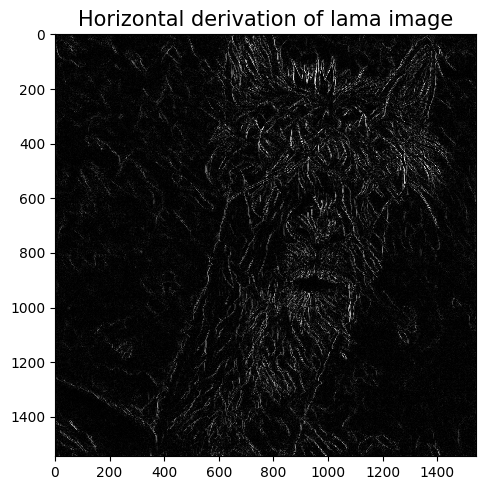

In [10]:
# In general deep learning (and in tensorflow) Conv-layers will 
# regard all channels and therefore use "cubic" filter

# The filter used here in the example down below is only using d=1 (two - dimensional) of the 
# rgb image (therefore red), you can change [:,:,0] to [:,:,1] (green) and [:,:,2] (blue)!
# Try it! :)
'''
*) Wieso sieht man hier gar kein Unterscheid ob man es auf der R,G oder B Schicht macht????????
'''

lama_x_prew = signal.convolve2d(lama[:,:,0], prewitt_x, boundary='symm', mode='same')
lama_x_prew = np.absolute(lama_x_prew)

fig, ax = plt.subplots(figsize=(figure_inches, figure_inches))
ax.set_title('Horizontal derivation of lama image', fontsize = 15)
ax.imshow(lama_x_prew, interpolation='nearest', cmap='gray')
plt.tight_layout()

But what is a convolutional layer anyways? Let's find out in the next section!

### 1.5.1 The Convolutional Layer

<img src="images/featuremaps.png" alt="Drawing" style="width: 600px;"/>

A convolutional layer, that could be the first layer in the network, is shown in the image above. Its kernel or filter with its dimensions $K_x \times K_y \times d$ contains weights that are updated during training and change the images' representation as well. One activation map equals one convolutional operation with one specific filter and the referring input image or spatial data of the previous layer. In most cases, not only one but several filters are learned in one convolutional layer so that there are multiple activation maps. In this particular case, the output size of this convolutional layer seems to have increased compared to the input size. In consequence, pooling operations are appended often to reduce the data within the network. The next layer receives then again spatial information and uses filters to extract and change the spatial information.

**Idea**: _`Sparse Connections` (not fully connected layers like in a MLP) given as kernels for big data structures. The number of learnable weights decreases!_

Let us compare a standard fully connected layer from a MLP with a convolutional layer for a regular colored image of size $256\times256\times3$:
- First hidden layer in a fully connected layer:
    - input neurons $\rightarrow$ $256*256*3$
    - start f.ex. with half the neurons in the first hidden layer $\rightarrow$ $128*256*3$
    - results in weights and biases $\rightarrow$ $256*256*3*128*256*3 + 128*256*3 = 19.327.451.136$ Parameters

        
- First convolutional layer in a convolutional neual network: standard 256 filters (reasonable size) of size $3\times3\times3$ 
    - weights and biases $\rightarrow$ $256 * 3 * 3 *3 + 256 = 7.168 $ Parameters
    
Nevertheless, convolutions with spatial blocks like in the figure above still need time to be processed.
Local information is used only not like global dependencies in hidden layers!

The **benefits** of a convolutional layer (`CONV`) in regards to a fully connected layer are the following:
 - Less parameters for training
 - Using the local structures of the image
 - Independent of the feature position in the image
 
**Downsides** of convolutional layers (`CONV`):
 - Information must have spatial dependencies (like in a humanly recognizable image)

When stacking multiple convolutional layer, one kernel of the following convolutional layer got shape $K_x \times K_y \times d$, where $d$ is the number of channels of the previous layer. The number of channels are given by the number of different filters that are used in the convolutional layer. So by defining a convolutional layer with $nb\_filters=64$ for example, you fix the third dimension of a filter in the next layer, because in the 2 dimensional case, the filter always expand to the previous channel dimension. If you consider CNNs for video analysis or time series, you might encounter 3 dimensional convolutional layer that do not only move in the image dimensions but a third dimension (in this case: time). 

### 1.5.2 The Pooling Layer

<img src="images/maxpool.png" alt="Drawing" style="width: 600px;"/>


                                     Source: http://cs231n.github.io/convolutional-networks/


The pooling layer is a filter like all other filters in the convolutional neural network except the fact that it does not update its weights and performs a fix functional operation. The most common pooling operation is Max Pooling. Like the name implies, inside the kernel's area only the maximum value is passed forward. Usually the stride equals the kernels dimensions and max pooling is applied only to the image's height and width, so that channel dimensions are not affected. It is used to reduce spatial information.

### 1.5.3 ReLU - Layer or Activation
The `RELU` layer or activation applys an elementwise activation function to the spatial volume like to each node in a hidden layer. The function can be given as $\phi_{relu}(x) = \max(0,x)$ and is depicted below. Consider $\phi(x)$ denoting the activation function.

<>:10: SyntaxWarning: invalid escape sequence '\p'
<>:10: SyntaxWarning: invalid escape sequence '\p'
/var/folders/9r/br8vmc6n7qs_ckhp47s0yxlc0000gn/T/ipykernel_13174/2206960604.py:10: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel("$\phi_{relu}(x)$")


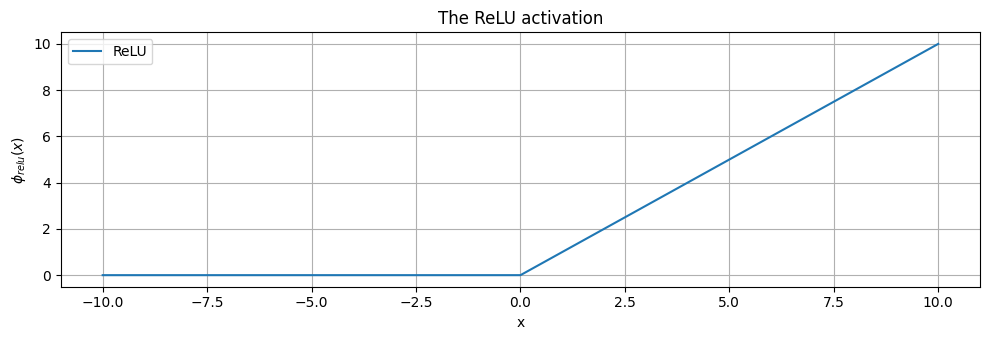

In [11]:
def relu(x: np.ndarray) -> np.ndarray:
    return np.maximum(0,x)
x = np.linspace(-10, 10, num = 1000)

plt.figure(2, figsize=(10,3.5))
plt.plot(x, relu(x), label='ReLU')
plt.title('The ReLU activation')
plt.legend()
plt.xlabel('x')
plt.ylabel("$\phi_{relu}(x)$")
plt.tight_layout()
plt.grid()

### 1.5.4 Summing it up

The following animation shows quite well how a convolutional network works based on the `MNIST` dataset.
After convolutional layers change the images' representation, the final multidimensional blocks are put into a long array (the operation is called "Flattening") and is fed to fully-connected layers of a neural network.

[MNIST-CLassification](http://scs.ryerson.ca/~aharley/vis/conv/flat.html)

### 1.5.5 Receptive Field

In the animation or simulation of MNIST, dependencies shown as lines between more than two layers are not depicted.
Nevertheless it is possible to show relations between arbitrary layers inside the network. By doing so, it is possible to achieve some knowledge or idea about the number of convolutional layers to use for an application or task. Consider three convolutional layers stacked over each other like in the image below. One value in the green layer relates to 9 input values. Consequently one value in the yellow layer sums up 9 in the green layer. So that one entry in the yellow layer is effected by more values than the green activation entries with regard to the input image. This area is shown in yellow and covers 49 values of the input image. To keep dimensions during convolutions like in usual CNNs, padding was used to keep the dimensions of the matrix the same. The `initial matrix` is then of size $7 \times 7$.

<img src="images/ReceptiveField.png" alt="Drawing" style="width: 600px;"/>

    Source:https://medium.com/mlreview/a-guide-to-receptive-field-arithmetic-for-convolutional-neural-networks-e0f514068807

<div class="alert alert-block alert-success">
<b>Question (2 pts):</b> What is the main difference between a convolutional and a fully-connected layer and why use filters at all? 
</div>

<div class="alert alert-block alert-success">
<b>Your Answer: In a fully-connected layer, as the name suggests, the neurons in the different layers are fully connected with each other, whereas in a convolutional layer this is not the case. Here, filters are applied to the input images, which helps to significantly reduce the number of parameters we need to use.</b> 
</div>
